In [1]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"

# tags = ['2024-04-12-15-31-26']
# filters = {"tags": {"$in": tags}}
tags = ["2024-05-03-14-02-27"]
filters = {"tags": {"$in": tags}, "state": "finished"}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [3]:
data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

# filter out runs with Evaluation/Mean_Returns == -100
df = df[df['Evaluation/Mean_Returns'] != -100]

ncols, nrows = df["ncols"][0], 6
df

100%|██████████| 12/12 [00:00<00:00, 1828.71it/s]


,_step,_wandb,_runtime,trajectories,Evaluation/Mean_Entropy,Evaluation/Entropies,Evaluation/Discounted_Returns,Evaluation/Mean_Discounted_Returns,_timestamp,Evaluation/Returns,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,0,{'runtime': 157},158.437362,"[[60, 48, 49, 37, 38, 39, 40, 41, 42, 43, 44, ...",0.338921,"{'values': [1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1...","{'values': [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",-15.97,1.714739e+09,"{'_type': 'histogram', 'bins': [-21, -20.875, ...",...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity
1,0,{'runtime': 93},94.266978,"[[60, 48, 49, 50, 51, 52, 53, 54, 42, 43, 44, ...",0.612779,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0...","{'bins': [-22, -21.890625, -21.78125, -21.6718...",-17.49,1.714738e+09,"{'values': [2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0...",...,0.3,4,identity,coordinate,0.000001,UCT,6,mvc,15,identity
2,0,{'runtime': 153},154.451052,"[[60, 48, 36, 24, 24, 24, 24, 25, 24, 24, 25, ...",0.762713,"{'_type': 'histogram', 'bins': [0.664069533348...","{'_type': 'histogram', 'bins': [-74, -73.14062...",-31.57,1.714738e+09,"{'_type': 'histogram', 'bins': [-74, -73.14062...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
3,0,{'runtime': 66},67.849240,"[[60, 48, 48, 49, 50, 38, 39, 40, 41, 42, 43, ...",0.400783,"{'bins': [0.30583852529525757, 0.3086901009082...","{'bins': [-23, -22.84375, -22.6875, -22.53125,...",-15.96,1.714738e+09,"{'values': [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0...",...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity
4,0,{'runtime': 48},49.263160,"[[60, 48, 49, 50, 51, 39, 27, 28, 29, 30, 31, ...",0.603175,"{'_type': 'histogram', 'bins': [0.448855489492...","{'_type': 'histogram', 'bins': [-21, -20.90625...",-17.08,1.714738e+09,"{'_type': 'histogram', 'bins': [-21, -20.90625...",...,0.3,4,identity,coordinate,0.000001,UCT,6,mvc,15,identity
5,0,{'runtime': 64},66.085333,"[[60, 48, 36, 36, 24, 25, 26, 27, 28, 29, 30, ...",0.788904,"{'_type': 'histogram', 'bins': [0.721941888332...","{'bins': [-48, -47.515625, -47.03125, -46.5468...",-23.74,1.714738e+09,"{'_type': 'histogram', 'bins': [-48, -47.51562...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
6,0,{'runtime': 29},30.494259,"[[60, 48, 49, 50, 51, 39, 40, 41, 42, 43, 44, ...",0.454947,"{'values': [1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1...","{'_type': 'histogram', 'bins': [-23, -22.84375...",-16.15,1.714738e+09,"{'_type': 'histogram', 'bins': [-23, -22.84375...",...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity
7,0,{'runtime': 25},26.914781,"[[60, 48, 48, 49, 50, 38, 39, 40, 41, 42, 43, ...",0.579974,"{'bins': [0.48715224862098694, 0.4897998273372...","{'_type': 'histogram', 'bins': [-25, -24.84375...",-17.00,1.714738e+09,"{'values': [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,0.3,4,identity,coordinate,0.000001,UCT,6,mvc,15,identity
8,0,{'runtime': 31},32.324577,"[[60, 48, 36, 37, 38, 39, 40, 28, 29, 30, 31, ...",0.828568,"{'bins': [0.7875618934631348, 0.78883552551269...","{'_type': 'histogram', 'bins': [-37, -36.67187...",-22.40,1.714738e+09,"{'_type': 'histogram', 'bins': [-37, -36.67187...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
9,0,{'runtime': 15},17.218736,"[[60, 48, 49, 50, 49, 50, 38, 39, 40, 41, 42, ...",0.490224,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [-22, -21.85937...",-16.49,1.714738e+09,"{'_type': 'histogram', 'bins': [-22, -21.85937...",...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity


In [45]:
# filter out 128 planning budget
# Assuming 'df' is your DataFrame
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']
# Define the policy combination renaming mapping
policy_combination_mapping = {
    'mvc+PolicyUCT': 'MVC+MVCUCT',
    'mvc+UCT': 'MVC+UCT',
    'visit+UCT': 'Visit+UCT'
}

# Rename the policy combinations in the DataFrame
df['policy_combination'] = df['policy_combination'].map(policy_combination_mapping)

# Group the DataFrame by both 'policy_combination' and 'planning_budget'
grouped = df.groupby(['policy_combination', 'planning_budget'])['trajectories']


# Aggregate the trajectories lists within each group
aggregated_trajectories = grouped.sum()
aggregated_trajectories


policy_combination  planning_budget
MVC+MVCUCT          16                 [[60, 48, 49, 50, 49, 50, 38, 39, 40, 41, 42, ...
                    32                 [[60, 48, 49, 50, 51, 39, 40, 41, 42, 43, 44, ...
                    64                 [[60, 48, 48, 49, 50, 38, 39, 40, 41, 42, 43, ...
                    128                [[60, 48, 49, 37, 38, 39, 40, 41, 42, 43, 44, ...
MVC+UCT             16                 [[60, 48, 49, 50, 38, 39, 40, 41, 42, 43, 44, ...
                    32                 [[60, 48, 48, 49, 50, 38, 39, 40, 41, 42, 43, ...
                    64                 [[60, 48, 49, 50, 51, 39, 27, 28, 29, 30, 31, ...
                    128                [[60, 48, 49, 50, 51, 52, 53, 54, 42, 43, 44, ...
Visit+UCT           16                 [[60, 48, 60, 48, 48, 49, 37, 38, 39, 40, 41, ...
                    32                 [[60, 48, 36, 37, 38, 39, 40, 28, 29, 30, 31, ...
                    64                 [[60, 48, 36, 36, 24, 25, 26, 27, 2

In [46]:
# remove all trajectories with a length of 100
print(aggregated_trajectories.apply(lambda x: len(x)).sum())
filtered_aggregated_trajectories = aggregated_trajectories.apply(lambda x: [traj for traj in x if len(traj) != 100])
# check the total number of trajectories
filtered_aggregated_trajectories.apply(lambda x: len(x)).sum()

1200


1200

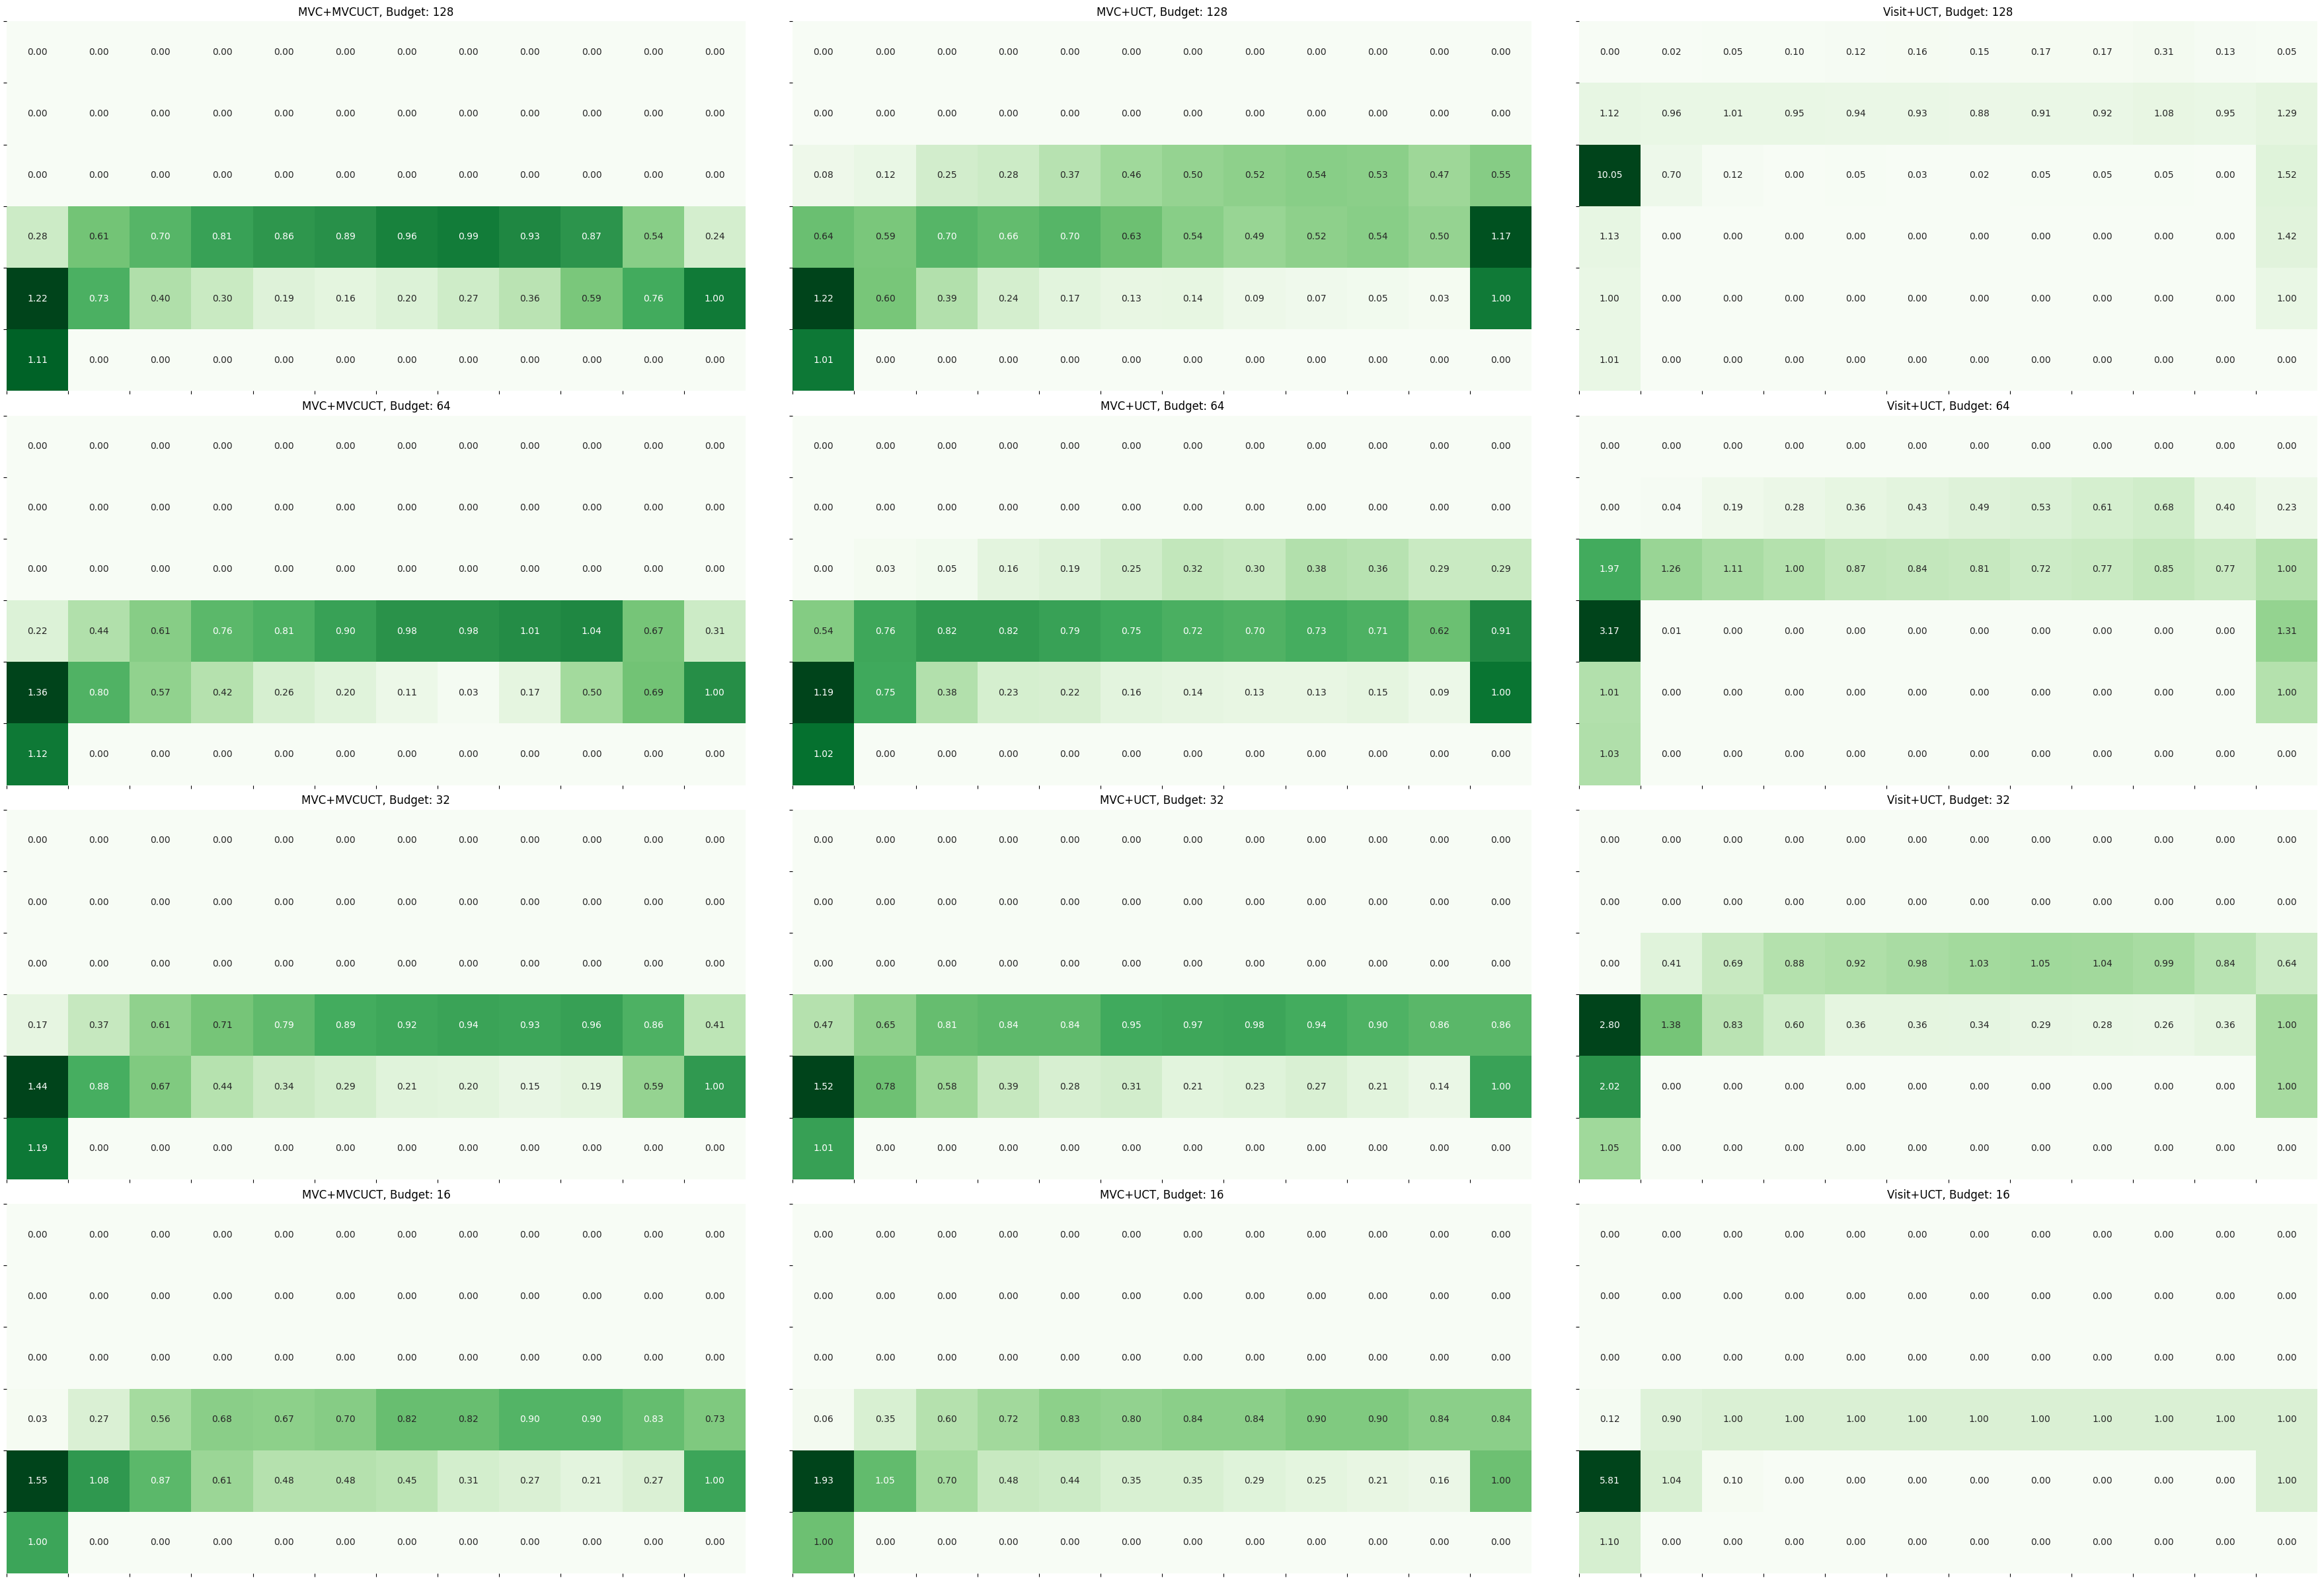

In [47]:
# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in filtered_aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs
    sns.heatmap(density, ax=ax, cmap='Greens', cbar=False, annot=True, fmt='.2f')
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square
    # set subtitle
    ax.set_title(f"{policy_combination}, Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/cliff_heurstic_density.pdf")
plt.show()


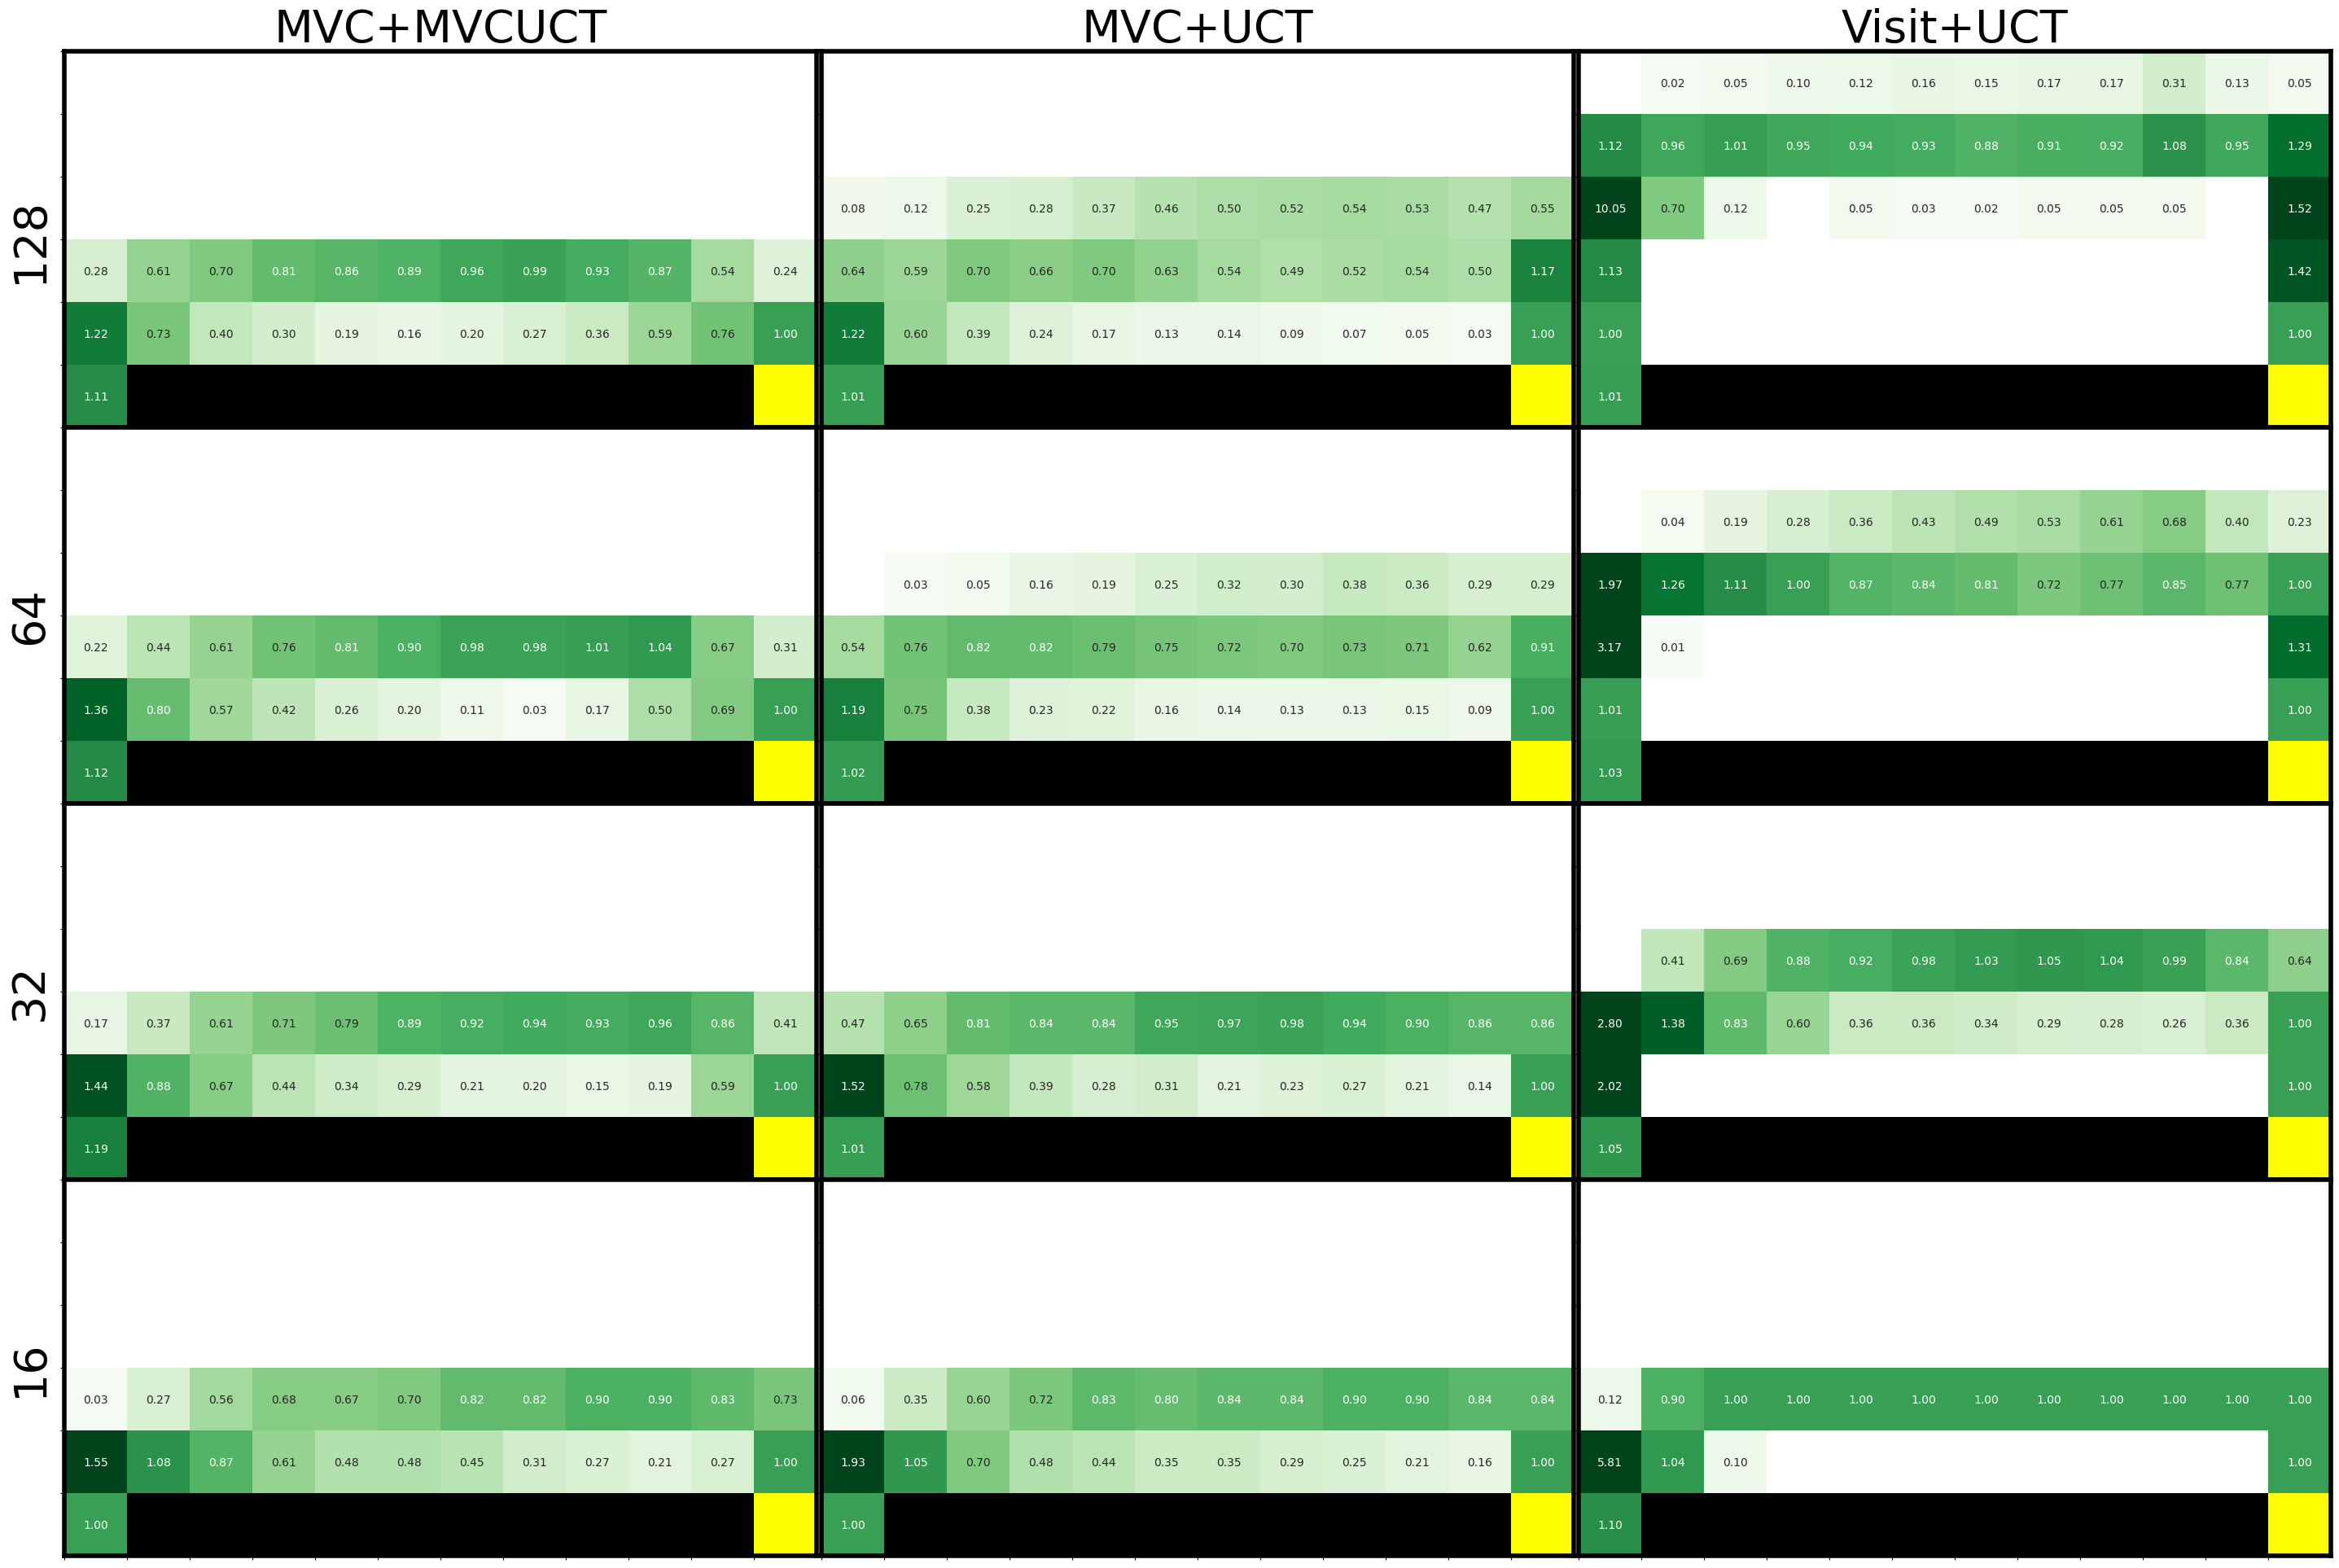

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Cliff and goal state coordinates
cliff_coords = [(nrows - 1, col) for col in range(1, ncols - 1)]
goal_coord = (nrows - 1, ncols - 1)

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in filtered_aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)

    # Set cliff and goal states to np.nan to hide their annotations
    for (row, col) in cliff_coords:
        density[row, col] = np.nan  # Remove numbers from the cliff cells
    goal_row, goal_col = goal_coord
    density[goal_row, goal_col] = np.nan  # Remove numbers from the goal cell

    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs

    # Create a custom colormap to highlight cliff and goal
    cmap = sns.color_palette("Greens", as_cmap=True)

    # Mask the 0.0 entries by setting them to NaN
    masked_density = density.copy()
    masked_density[masked_density == 0.0] = np.nan

    # Create a normalization instance with clip=True to ensure values above 1.5 are clipped
    norm = colors.Normalize(vmin=1e-3, vmax=1.5, clip=True)

    # Plot the heatmap
    sns.heatmap(masked_density, ax=ax, cmap=cmap, cbar=False, annot=True, fmt='.2f', mask=np.isnan(masked_density), norm=norm)
    # Use LogNorm for logarithmic color scaling
    # sns.heatmap(density, ax=ax, cmap=cmap, cbar=False, annot=True, fmt='.2f', mask=np.isnan(density), norm=colors.Normalize(1e-3, 1.5, clip=True))

    # Highlight the cliff states with black color
    for (row, col) in cliff_coords:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=True, color='black', lw=0))

    # Highlight the goal state with yellow color
    ax.add_patch(plt.Rectangle((goal_col, goal_row), 1, 1, fill=True, color='yellow', lw=0))

    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square

    # Set labels for the outer plots with larger font size
    if i == 0:
        ax.set_title(policy_combination, fontsize=40)
    if j == 0:
        ax.set_ylabel(f"{planning_budget}", fontsize=40)

# Adjust layout to remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Add a border around each subplot
for ax in axs.flat:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(4)

plt.savefig("outfiles/cliff_heurstic_density.pdf", bbox_inches='tight')
plt.show()


In [49]:
df["policy_combination"].unique()

array(['MVC+MVCUCT', 'MVC+UCT', 'Visit+UCT'], dtype=object)

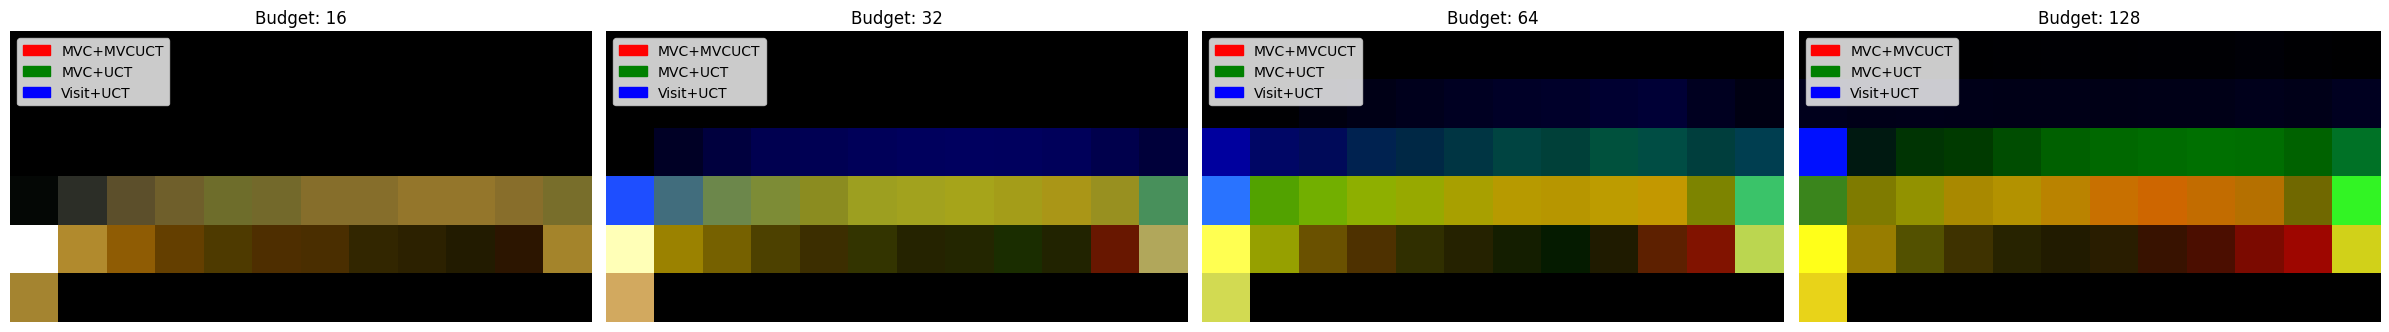

In [50]:
import matplotlib.patches as mpatches
grouped = df.groupby(['planning_budget', 'policy_combination'])['trajectories'].sum()


# Determine the number of unique planning budgets
n_budgets = len(grouped.index.get_level_values(0).unique())

# Prepare a single figure with multiple subplots (one for each planning_budget)
fig, axs = plt.subplots(1, n_budgets, figsize=(6 * n_budgets, 6))

# Iterate over each planning_budget and create RGB heatmaps
for idx, (planning_budget, budget_group) in enumerate(grouped.groupby(level=0)):
    rgb_image = np.zeros((nrows, ncols, 3))  # Initialize RGB layers
    colors = ['Red', 'Green', 'Blue']  # Map trajos keys to RGB channels
    channel_colors = {name: color for name, color in zip(budget_group.index.get_level_values(1), colors)}

    # Compute density for each policy combination and assign to RGB channels
    for jdx, ((_, policy_combination), trajectories) in enumerate(budget_group.items()):
        density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
        norm_density = density / np.max(density, where=(density!=0), initial=1)  # Normalize avoiding division by zero
        rgb_image[:, :, jdx % 3] += norm_density  # Accumulate in RGB layers, repeating colors if more than 3 policies

    ax = axs[idx] if n_budgets > 1 else axs
    ax.imshow(rgb_image, aspect='equal')
    ax.axis('off')  # Hide grid lines and labels

    # Create a legend
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in channel_colors.items()]
    ax.legend(handles=legend_patches, loc='upper left')
    ax.set_title(f"Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/dist_training_cliff_rgb.pdf")
plt.show()

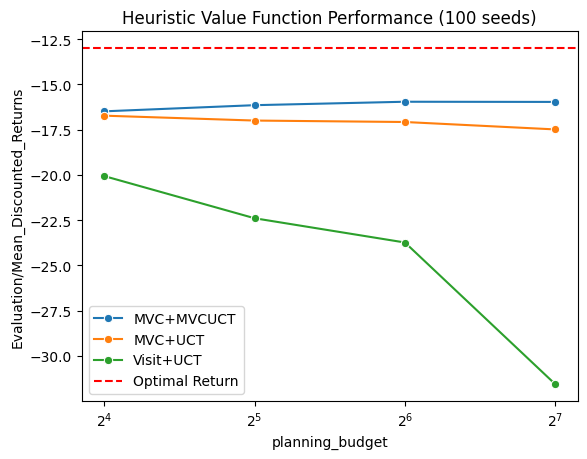

In [51]:
# plot Evaluation/Mean_Discounted_Returns from df vs planning_budget for each policy_combination

sns.lineplot(data=df, x='planning_budget', y='Evaluation/Mean_Discounted_Returns', hue='policy_combination', marker='o')
optimal_value = -13
plt.axhline(optimal_value, color='red', linestyle='--', label='Optimal Return')
# set x axis to log2 scale
plt.xscale('log', base=2)
plt.legend()
plt.title('Heuristic Value Function Performance (100 seeds)')
plt.savefig("outfiles/heuristic_value_function_performance.pdf")
plt.show()
